In [3]:
#%% Imports
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 15 16:38:45 2023

Notebook for force calculations.

cleaned script for data analysis and figure plotting for force sensor setup paper

1. import libraries
2. import main excel file
3. import tracking data (support position, contact position,2 stem points near support)
4. import results from root_stem_extractor
5. remove problematic events from raw data
6. populate event-class variables
9. figures:
    1. example: X,Y,Z position of support
    2. example: angle of support
    3. example: Force trajectory of 1 twine and 1 slip
    4. Radius and Young's modulus fits (probably not in this article)
    5. Force trajectories for different support masses

@author: Amir Ohad
"""
#%% import libraries
# generic
import sys
import numpy as np
import os,glob # for listing files in folder
import re # regular expressions
import pandas as pd
import scipy
import seaborn
import math as m
from scipy.signal import savgol_filter
from scipy.spatial import distance as sci_distance
from scipy.stats import kruskal

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import random
import itertools
# from progress_bar import InitBar
from tqdm import tqdm
import pickle as pkl
import datetime
now = datetime.datetime.now()

# custom
import exp2funcs_clean
sys.path.append('..')
import useful_functions as uf 

# import error_estimates

#general parameters
cmap = plt.get_cmap('viridis')
fs = 16 # standard font size for plots

# unit conversion for paper figures
mg2mN = 1/100
mg2uN = 1*10


In [4]:

#%% import data 
root_path = r'C:\Users\Amir\Documents\PHD\Experiments\Force Measurements'
basepath = root_path+r'\Exp2_Pendulum' # pendulum exp folder
excel= r'\Exp2_supplementary_measurements_events.csv'

# straw exp data
data_panda = pd.read_csv(basepath+excel)


# import tracked data, initiate variables
track_sup_path = r'\track_logs'
track_folder_path = basepath+track_sup_path

track_contact_path = r'\contact_track_logs'
contact_folder_path = basepath+track_contact_path

track_near_sup_path = r'\twine_init_logs'
track_near_sup_folder_path = basepath+track_near_sup_path

h5_path = r'\Measurements\root_stem_results'
h5_folder_path = basepath+h5_path

E_path = r'\Young_moduli'
E_folder_path = basepath+E_path

N_track = len(os.listdir(track_folder_path)) # get number of files in track folder
N_contact=len(os.listdir(contact_folder_path)) # get number of files in contact folder
N_tot = len(data_panda) # get number of lines in excel
N_E = len(os.listdir(E_folder_path))


#%% remove problematic events from raw data
delete_rows = [] # save rows to delete
problem_exp = [] # exp_num of problem events

for i in range(N_tot): # remove problem events and non-Helda events
    if data_panda.at[i,'problem']!='na' or data_panda.at[i,'Bean_Strain']!='Helda':
        delete_rows.append(i)
        problem_exp.append(data_panda.at[i,'Exp_num'])
N = N_tot - len(delete_rows) # modify num of rows

data_panda = data_panda.drop(data_panda.index[delete_rows]) # remove prob. events
data_panda = data_panda.reset_index() # redo index
#%% get misc. file lists

# get track files for support bottom coordinates
remove_chars = re.compile('[,_\.!?]') # what to remove from strings
track_dict = {} # save support track in dictionary by exp and events
i=0 # start with first track file
for file in glob.glob(os.path.join(track_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('[0-9]',re.findall('_\d{1}\D',file)[0].replace('_',''))[0]) # find event number
    viewt = re.findall('(side{1}|top{1})',file)[0] #.replace('_','')
    track_dict[(exp,event,viewt)] = [file] # add new exp
    i+=1

# get track files for stem-support contact coordinates
contact_dict = {} # save support contact track in dictionary by exp and events
i=0 # start with first contact file
for file in glob.glob(os.path.join(contact_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('_[0-9]_',file)[0].replace('_','')) # find event number
    contact_dict[(exp,event)] = [file] # add new exp
    i+=1

# get track files for 2 stem positions on either side of support
near_sup_track_dict = {}
i=0 # start with first stem_near_sup file
for file in glob.glob(os.path.join(track_near_sup_folder_path, '*.txt')): # for each event:
    exp = int(re.findall('_\d{3,4}_',file)[0].replace('_','')) # find exp number (3-4 digits)
    event = int(re.findall('_[0-9]_',file)[0].replace('_','')) # find event number
    near_sup_track_dict[(exp,event)] = [file] # add new exp
    i+=1

# get h5 files for stem near support
h5_dict = {}
i=0 # start with first h5 file
for file in glob.glob(os.path.join(h5_folder_path, '*.h5')): # for each event:
    exp = int(re.findall('interekt_\d{2,3}_',file)[0].split('_')[1]) # find exp number (3-4 digits)
    event = int(re.findall('e_[0-9]_',file)[0].split('_')[1]) # find event number
    start_frame = int(re.findall('_\d{2,5}-\d{2,5}',file)[0].replace('_','').split('-')[0]) # find start frame
    h5_dict[(exp,event,start_frame)] = [file] # add new exp
    i+=1

# get Young modulus files
E_dict = {}
for file in glob.glob(os.path.join(E_folder_path, '*.csv')):
    exp = int(re.findall('\d{2,3}',file)[0])
    E_dict[exp]=pd.read_csv(file,header=None)

#%%

In [5]:
#%% clear plants and events
plants = []
events = []
#%% populate plant and event instances
i = 0
N = len(data_panda)
for i in tqdm(range(N)): # N
    exp = int(re.findall('\d{3,4}',data_panda.at[i,'Exp_num'])[0]) # exp num
    view = data_panda.at[i,'View']  # side of top view
    if view == 'top':
        plants[-1].pix2cm_t = float(data_panda.at[i,'Top_pix2cm'])

    if i==0 or exp!=plants[-1].exp_num: # append new plant with data from pandas
        #basic data
        plants.append(exp2funcs_clean.Plant(data_panda,basepath,i,exp))
        # view dependent data
        plants[-1].view_data(data_panda,i)
        # circumnutation data
        plants[-1].cn_data(data_panda,i)
        #Youngs modulus by segment with avg
        plants[-1].getE(E_dict)


    event =  int(re.findall('_[0-9]',data_panda.at[i,
       'Exp_num'])[0].replace('_','')) # get event number


    # if this is the 1st event or the previous event_num is different from the current one:
    # add new event to list
    if len(events)==0 or events[-1].event_num != event or \
        events[-1].p.exp_num != exp:
        events.append(exp2funcs_clean.Event(plants[-1],data_panda,i))
    events[-1].event_num = event

    # view dependent data
    events[-1].view_data(data_panda,i,view)

    # get automated extraction of twine(decision) time
    events[-1].get_twine_time(exp,event,view,
                      h5_dict,near_sup_track_dict,50,track_dict,to_plot=0)


    # get track data, select decision period data, pix2cm,
    events[-1].event_base_calcs(view,track_dict,contact_dict)
    # calc
    events[-1].event_calc_variables(view)
    # print(f'i={i}, exp number {exp}, {event}') # print progress


  0%|          | 0/264 [00:00<?, ?it/s]

100%|██████████| 264/264 [00:09<00:00, 26.67it/s]


Twine:True
Slip:True


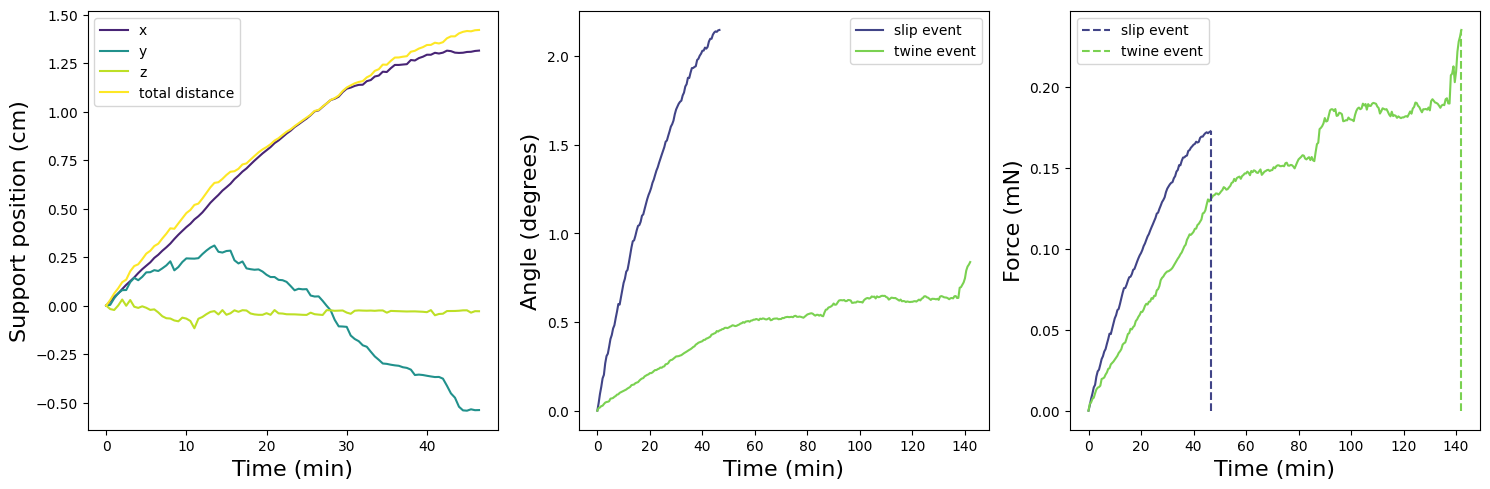

In [31]:
#%% figure - Force trajectory of 1 twine and 1 slip

i_slip = 40
i_twine = 50

# check events are correctly classified
print("Twine:"+ str(events[i_twine].twine_state==1))
print("Slip:"+ str( events[i_slip].twine_state==0))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xyz coordinates
axs[0].plot(events[i_slip].timer/60, xyz[0,::]-xyz0[0,::], color=cmap(0.1), label='x')
axs[0].plot(events[i_slip].timer/60, xyz[1,::]-xyz0[1,::], color=cmap(0.5), label='y')
axs[0].plot(events[i_slip].timer/60, xyz[2,::]-xyz0[2,::], color=cmap(0.9), label='z')
axs[0].plot(events[i_slip].timer/60, events[i_slip].trk_dist, color=cmap(1.5), label='total distance')
axs[0].set_xlabel('Time (min)', fontsize=fs)
axs[0].set_ylabel('Support position (cm)', fontsize=fs)
axs[0].legend()

# Plot angle
axs[1].plot(events[i_slip].timer/60, np.rad2deg(events[i_slip].alpha), color=cmap(0.2), label='slip event')
axs[1].plot(events[i_twine].timer/60, np.rad2deg(events[i_twine].alpha), color=cmap(0.8), label='twine event')
axs[1].set_xlabel('Time (min)', fontsize=fs)
axs[1].set_ylabel('Angle (degrees)', fontsize=fs)
axs[1].legend()

# Plot calculated force
axs[2].plot(events[i_slip].timer/60, np.multiply(events[i_slip].F_bean, mg2mN), color=cmap(0.2))
axs[2].plot(events[i_twine].timer/60, np.multiply(events[i_twine].F_bean, mg2mN), color=cmap(0.8))
axs[2].set_xlabel('Time (min)', fontsize=fs)
axs[2].set_ylabel('Force (mN)', fontsize=fs)
axs[2].vlines(events[i_slip].timer[-1]/60, 0, events[i_slip].F_bean[-1]*mg2mN, color=cmap(0.2), linestyle='dashed', label='slip event')
axs[2].vlines(events[i_twine].timer[-1]/60, 0, events[i_twine].F_bean[-1]*mg2mN, color=cmap(0.8), linestyle='dashed', label='twine event')
axs[2].legend()

plt.tight_layout()
plt.show()

print('should I include the contact height over time?')

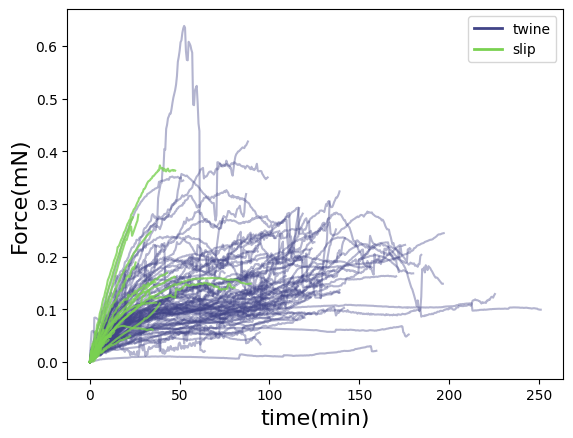

In [7]:
#%% S1- all twine/slip events
from matplotlib.lines import Line2D
savep = 0
legend_elements = [Line2D([0], [0], color=cmap(0.2), lw=2, label='twine'),
                   Line2D([0], [0], color=cmap(0.8), lw=2, label='slip')]
# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='best')

for i in range(len(events)):
    # Tcn = events[i].Tcn
    if events[i].twine_state==1:
        plt.plot(events[i].timer/60,np.multiply(events[i].F_bean,mg2mN),
                 color=cmap(0.2),alpha=0.4)
for i in range(len(events)):
    if events[i].twine_state==0:
        plt.plot(events[i].timer[:-7]/60,np.multiply(events[i].F_bean[:-7],mg2mN),
                 color=cmap(0.8),alpha=0.8)

plt.xlabel('time(min)',fontsize=fs)
plt.ylabel('Force(mN)',fontsize=fs)

plt.show()
#%%

min(a)=74.0,max(a)=195.625


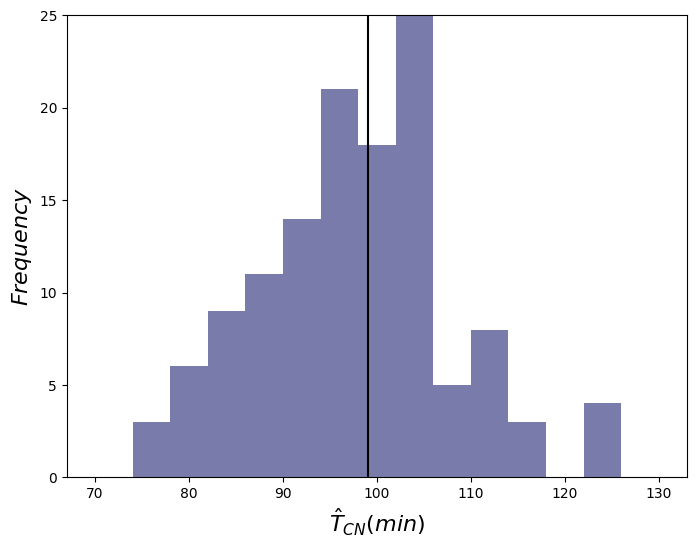

In [8]:
#%% plot T_cn distribution
# this is for plants of l_arm ~ 10-20 cm
plt.figure(figsize=(8, 6))
a = []
nbin = 15
for i in range(len(events)):
    a.append(events[i].p.avgT)
bin_range = [70,130]

n = plt.hist(a,bins=nbin,range=bin_range,color = cmap(0.2),alpha=0.7)
plt.xlabel(r'$\hat{T}_{CN}(min)$',fontsize=fs)
plt.ylabel(r'$Frequency$',fontsize=fs)
plt.vlines(np.mean(a), 0, max(a),'k')
plt.ylim([0,25])
print(f'{min(a)=},{max(a)=}')
#%%

C:\Users\Amir\AppData\Local\Temp\ipykernel_17288\3283761839.py:75: RuntimeWarning: invalid value encountered in divide
  ratio = (hist_slip[0] - hist_twine[0] )/ (hist_slip[0] + hist_twine[0] )


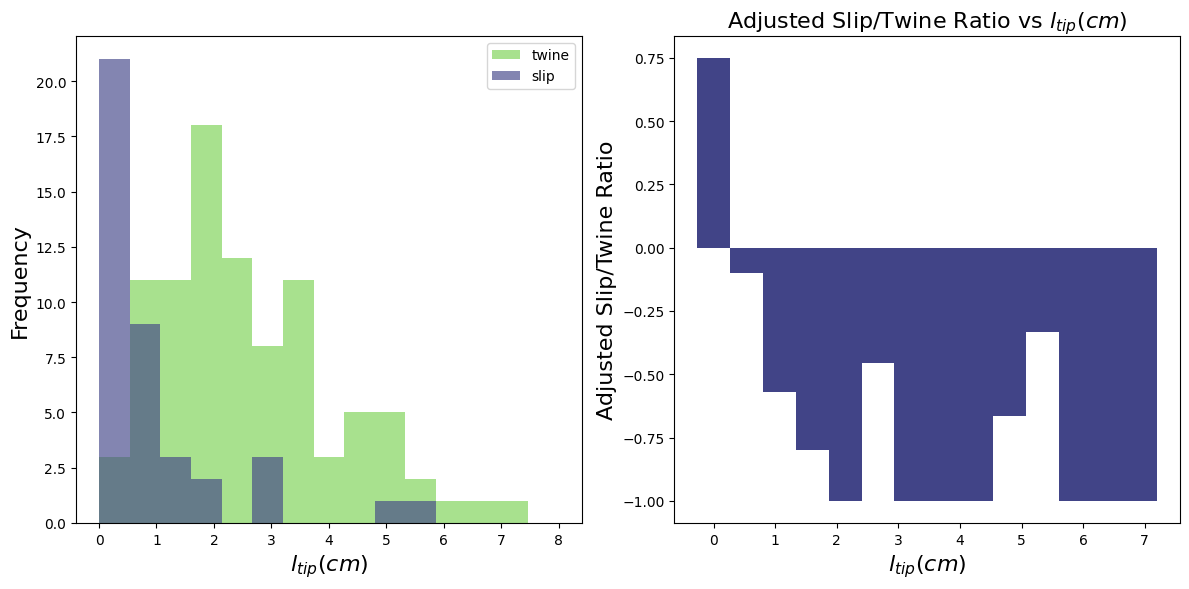

check high (var) values for slip events


In [32]:
#%% twine/slip probability graphs
var_slip = []
var_twine = []
var_name = [r'$\int\epsilon_{max}dt$ (sec)',r'$\epsilon_{max}$',
            r'$\int Fdt (mgf*sec)$', r'$T_{dec}/T_{cn}$','W(Fmg*cm)',
            r'$l_{tip} (cm)$','$F_{max}$ (mgf)',r'$\tau_{max}(mgf*cm)$',
            r'$\int \tau dt(mgf*cm*s)$']
x_range = [[0,2e2],[0,0.5e-1],[0,2.5e5],[0,2.5],
           [0,40],[0,8],[0,60],[0,4e2],[0,3e6]]
value_name = 'frequency' # density
n_tot = len(events)
n_tests = int(5e5)
n_bins = 15
# choose a comparison
# 0: integrated strain
# 1: max strain
# 2: integrated force
# 3: normalized decision time
# 4: work
# 5: contact distance from stem tip
# 6: max force until dec
# 7: max torque
# 8: integrated torque
k = 5
# compare: integ_f, alpha, F_bean, L_contact2stemtip_cm,
# F1stmax , L_base,dec_time, p.avgT, int_eps

# save values to 2 lists
for i in range(n_tot):
    #if events[i].p.exp_num==69 and events[i].event_num==1 or\
    #    events[i].p.exp_num==98 and events[i].event_num==2: continue
    # cutoffs
    try:
        if k==0: var = events[i].int_eps
        elif k==1: var = max(events[i].eps_t)
        elif k==2: var = events[i].integ_f
        elif k==3: var = events[i].dec_time/events[i].p.avgT # key parameter
        elif k==4: var = events[i].work
        elif k==5: var = events[i].L_contact2stemtip_cm # key parameter
        elif k==6: var = max(events[i].F_bean)
        elif k==7: var = max(events[i].torque)
        elif k==8: var = events[i].integ_torque

    except:
        continue

    if events[i].twine_state == 1:
        var_twine.append(var)# set variable to plot
    else:
        var_slip.append(var)

# create pandas df
df1 = pd.DataFrame(var_twine,columns=['twine'])
df2 = pd.DataFrame(var_slip,columns=['slip'])
df = pd.concat([df1,df2], axis=1)

# pandas histogram
hist_twine = np.histogram(df1,bins=n_bins,range=x_range[k])
hist_slip = np.histogram(df2,bins=n_bins,range=x_range[k])

# Plot the adjusted ratio and histogram as subfigures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Variable histogram
df.plot.hist(stacked=False, bins=n_bins, ax=ax1, grid=False, range=x_range[k], density=False,
             color=[cmap(0.8), cmap(0.2)], alpha=0.65)
ax1.set_xlabel(var_name[k], fontsize=fs)
ax1.set_ylabel('Frequency', fontsize=fs)

# Calculate normalized ratio between slip and twine events per bin
ratio = (hist_slip[0] - hist_twine[0] )/ (hist_slip[0] + hist_twine[0] )
ratio_mod = []

# Get the number of events in each bin for twine and slip
twine_counts, _ = np.histogram(df1, bins=n_bins, range=x_range[k])
slip_counts, _ = np.histogram(df2, bins=n_bins, range=x_range[k])

# Adjusted Slip/Twine Ratio
ax2.bar(hist_twine[1][:-1], ratio, width=np.diff(hist_twine[1]), color=cmap(0.2))
ax2.set_xlabel(var_name[k], fontsize=fs)
ax2.set_ylabel('Adjusted Slip/Twine Ratio', fontsize=fs)
ax2.set_title('Adjusted Slip/Twine Ratio vs ' + var_name[k], fontsize=fs)
plt.tight_layout()
plt.show()

# Divide the ratio by the total number of events for all bins
# ratio /= (twine_counts + slip_counts) # does this make sense?

print('check high (var) values for slip events')
#%%

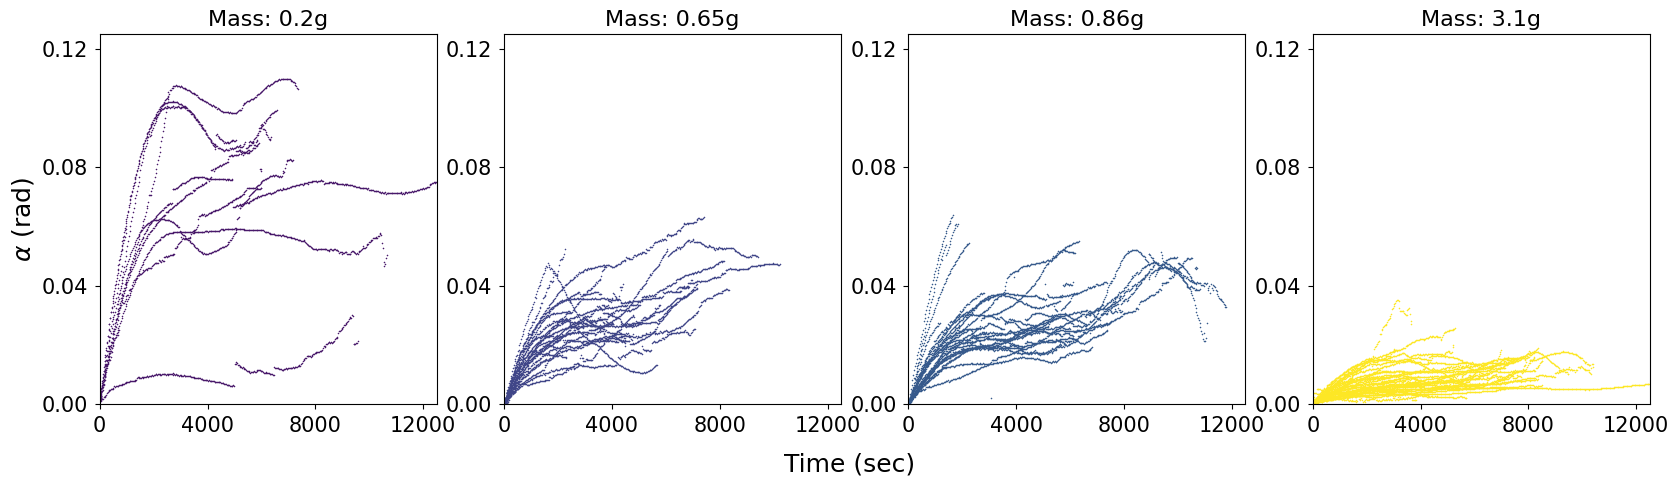

In [10]:
#%% Plot trajectories for different support masses
mass = [0.2,0.65,0.86,3.1]

fig, ax = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.text(0.5, -0.03, 'Time (sec)', ha='center', fontsize=fs+2)
for i in range(len(mass)):
    ax[i].set_ylim([0, 0.125])
    ax[i].set_xlim([0, 12500])
    ax[i].tick_params(axis='both', which='major', labelsize=fs-1)
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].xaxis.set_tick_params(pad=5)
    ax[i].yaxis.set_tick_params(pad=5)
    ax[i].set_title(f"Mass: {mass[i]}g", fontsize=fs)
ax[0].set_ylabel(r"$\alpha$ (rad)", fontsize=fs+2)
for i in range(len(events)):
    if events[i].p.m_sup in mass:
        index = mass.index(events[i].p.m_sup)
        ax[index].plot(events[i].timer, events[i].alpha,
                       'x',markersize=0.5,color=cmap(mass[index]/max(mass)))
#%%